In [1]:
# imports
import os, sys

# voxel morph imports
import tensorflow as tf
import voxelmorph as vxm
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import numpy as np
import scipy.ndimage as ndi
import h5py
import cv2

import utilitary as util

#plotting
import matplotlib.pyplot as plt
import neurite as ne

In [2]:
hf = h5py.File("../epfl3.h5", "r")

In [3]:
nb_entries = len(hf.keys())
list_keys = list(hf.keys())
keys_random = np.random.permutation(list_keys)

x,y,z = hf.get("0")["frame"][0].shape

In [4]:
def dice_coef(pred, true, k = 0):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [5]:
masks = []
frames_masks = []
frames_no_masks = []
for i,key in enumerate(list_keys):
    a = hf.get(key)
    if len(a) > 1:
        masks.append(hf.get(key)["mask"])
        frames_masks.append(hf.get(key)["frame"])
    else:
        frames_no_masks.append(hf.get(key)["frame"])
np_masks = np.array(masks)
np_frames_masks = np.array(frames_masks)
np_frames_no_masks = np.array(frames_no_masks)

In [6]:
del masks
del frames_masks
del frames_no_masks

In [7]:
np_masks.shape

(118, 112, 112, 32)

In [8]:
np_frames_masks.shape

(118, 1, 112, 112, 32)

In [9]:
np_frames_no_masks[0][0][:,:,1].shape

(112, 112)

In [10]:
y_true = np_frames_masks[0]
y_pred = np_frames_no_masks[0]
lab = np_masks

In [20]:
dice_score = dice_coef(lab[0],lab[3])
dice = 1 - dice_score
print(dice)

0.41915411933902735


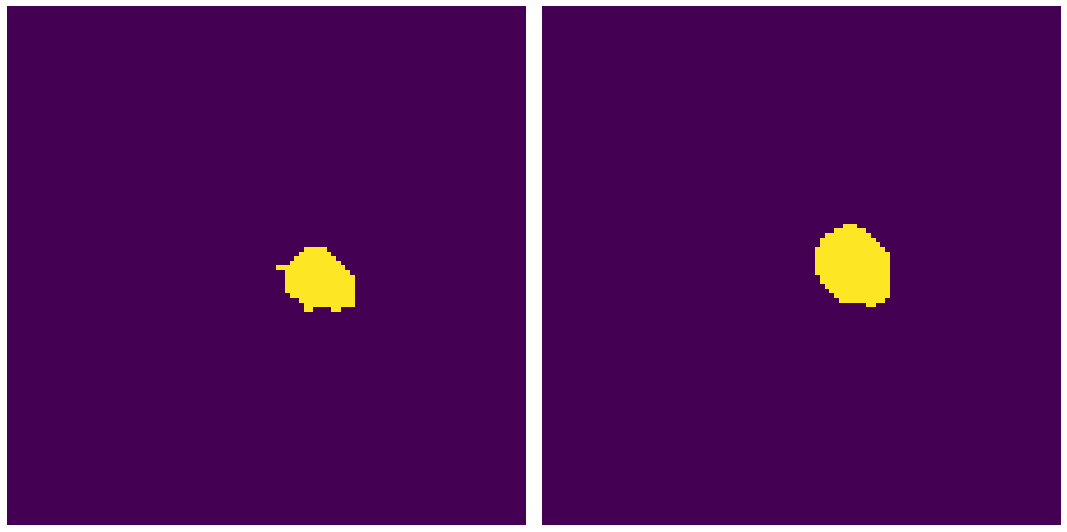

(<Figure size 1080x540 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012255548>,
       dtype=object))

In [21]:
ne.plot.slices([lab[0][:,:,i], lab[3][:,:,18]])

In [5]:
np.random.seed(336699)

nb_entries = len(hf.keys())
list_keys = list(hf.keys())
keys_random = np.random.permutation(list_keys)

keys_train = keys_random[:int(nb_entries*0.8)]
keys_test  = keys_random[int(nb_entries*0.8):]

In [6]:
# print keys in test with labels mask
mask_tests = []
for i in keys_test[300:]:
    if len(hf.get(i)) > 1:
        mask_tests.append(i)

In [7]:
#load the training set + normalization
slices_train_3d_frame = np.empty((len(mask_tests),112,112,32), dtype=np.int16)
slices_train_3d_mask = np.empty((len(mask_tests),112,112,32), dtype=np.int16)
for i, key in enumerate(mask_tests):
    slices_train_3d_frame[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
    slices_train_3d_mask[i] = np.array(hf.get(key)["mask"])

In [8]:
vol_shape = (112, 112, 32)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

vxm_model = vxm.networks.VxmDense(inshape=vol_shape,
                                  nb_unet_features=nb_features,
                                  int_steps=0);

fixed_vol = np.array(hf.get('853')["frame"][0][:,:,:])/255

lambda_ = 0.1
title = "wght_3d_" + str(lambda_) + ".keras"
vxm_model.load_weights(title)

predict_generator = util.vxm_data_generator(slices_train_3d_frame,
                                          vol_fixed=fixed_vol,
                                          batch_size=1)

#val_input = next(predict_generator)
#val_input[1].shape
# predict the transformation
val_pred = vxm_model.predict(next(predict_generator));
#pred_warp = [i[1] for i in val_pred]

#warp_generator = util.vxm_data_generator(slices_train_3d_mask,
                                         # vol_fixed=fixed_vol,
                                          #batch_size=1)

Instructions for updating:
Use fn_output_signature instead


In [9]:
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

In [10]:
fixed_seg = np.array(hf.get('853')["mask"])

In [14]:
# predict the labels transformation
warped_seg = warp_model.predict([slices_train_3d_mask[0][np.newaxis,...,np.newaxis], val_pred[1]])
#[i[np.newaxis,...,np.newaxis] for i in slices_train_3d_mask]

In [ ]:
# ROLL THE DICE -> Before warping
dice_score = dice_coef(fixed_seg,slices_train_3d_mask[0])
dice = 1 - dice_score
print(dice)

In [15]:
# ROLL THE DICE -> after warping
dice_score = dice_coef(warped_seg.squeeze(),fixed_seg)
dice = 1 - dice_score
print(dice)

0.6238496798348437


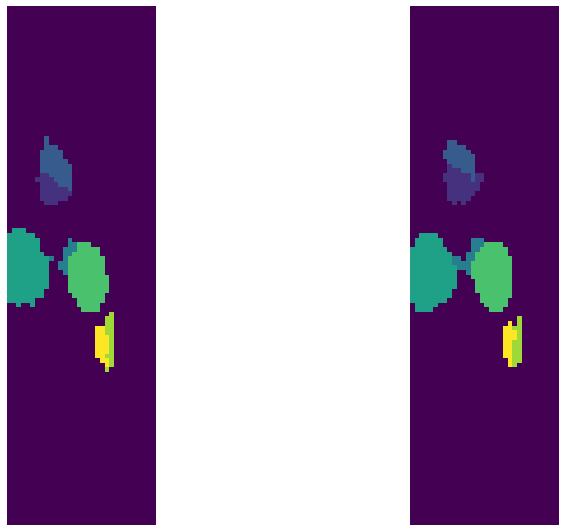

(<Figure size 1080x540 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000175F9548>,
       dtype=object))

In [27]:
ne.plot.slices([np.max(fixed_seg, axis=1), np.max(slices_train_3d_mask[0],axis=1)])

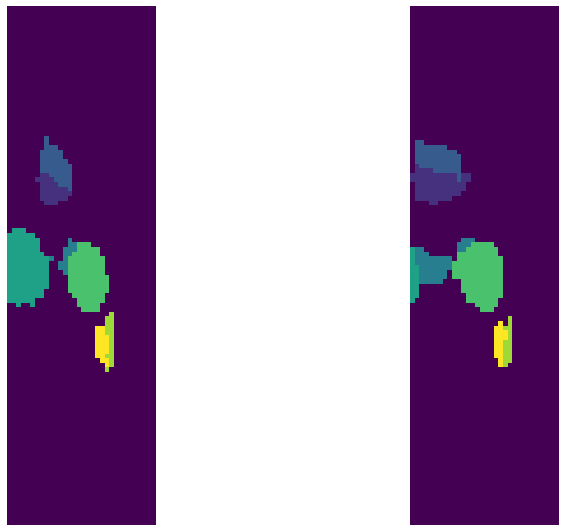

(<Figure size 1080x540 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000176A5988>,
       dtype=object))

In [28]:
ne.plot.slices([np.max(fixed_seg, axis=1), np.max(warped_seg.squeeze(),axis=1)])

# Semi-supervised (Code pas terminé à partir de là)

In [ ]:
# keys with labels mask
masked_train = [i for i in keys_train if (len(hf.get(i)) > 1)]
masked_test = [i for i in keys_test if (len(hf.get(i)) > 1)]

labels_train_3d_semisup = np.zeros((len(masked_train),112,112,32))
slices_train_3d_semisup = np.zeros((len(masked_train),112,112,32))

labels_test_3d_semisup = np.zeros((len(masked_test),112,112,32))
slices_test_3d_semisup = np.zeros((len(masked_test),112,112,32))

#load the training set + normalization
for i, key in enumerate(masked_train):
    labels_train_3d_semisup[i] = np.array(hf.get(key)["mask"][0])/255
    slices_train_3d_semisup[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

    #load the test set + normalization
for i, key in enumerate(masked_test):
    labels_test_3d_semisup[i] = np.array(hf.get(key)["mask"][0])/255
    slices_test_3d_semisup[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

In [ ]:
# our data will be of shape 112 x 112 x 32
vol_shape = (112, 112, 32)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

#lambda_param = 0.05
#loss_weights = [1, lambda_param]
lambda_ = 0.05
title = "wght_3d_" + str(lambda_) + ".keras"
warps = vxm_model_semisup.load_weights(title)

# declare the model, using all 7 labels values
vxm_model_semisup = vxm.networks.VxmDenseSemiSupervisedSeg(inshape=vol_shape,
                                                           nb_labels=7,
                                                           nb_unet_features=nb_features,
                                                           int_steps=0);

vxm_model_semisup.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                          loss=losses,
                          loss_weights=loss_weights)

In [ ]:
# generate a file for each semi-supervised training entry
for i in range(len(slices_train_3d_semisup)):
    savez_compressed('vol'+str(i)+'.npz',
                     vol=slices_train_3d_semisup[i],
                     seg=labels_train_3d_semisup[i])
    
vols_names = ['vol'+str(i)+'.npz' for i in range(len(slices_train_3d_semisup))]

In [ ]:
# create the generator
label_vals = np.array([1,2,3,4,5,6,7])
train_generator = vxm.generators.semisupervised(vol_names=vols_names,
                                                labels=label_vals
                                               )

In [ ]:
val_generator = util.vxm_data_generator(lab, 12, batch_size = 15)
val_input, zero_phi = next(val_generator_gr)
our_val_pred_gr = vxm_model.predict([val_input[1],val_input[0]]);

In [ ]:
transform_model = vxm.networks.Transform(inshape, interp_method='nearest')
val_pred = vxm_model.predict([])

In [217]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))

In [224]:
def dice(pred, true, k = 0):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [225]:
dice_score = dice(lab[0],lab[0])
dice = 1 - dice_score

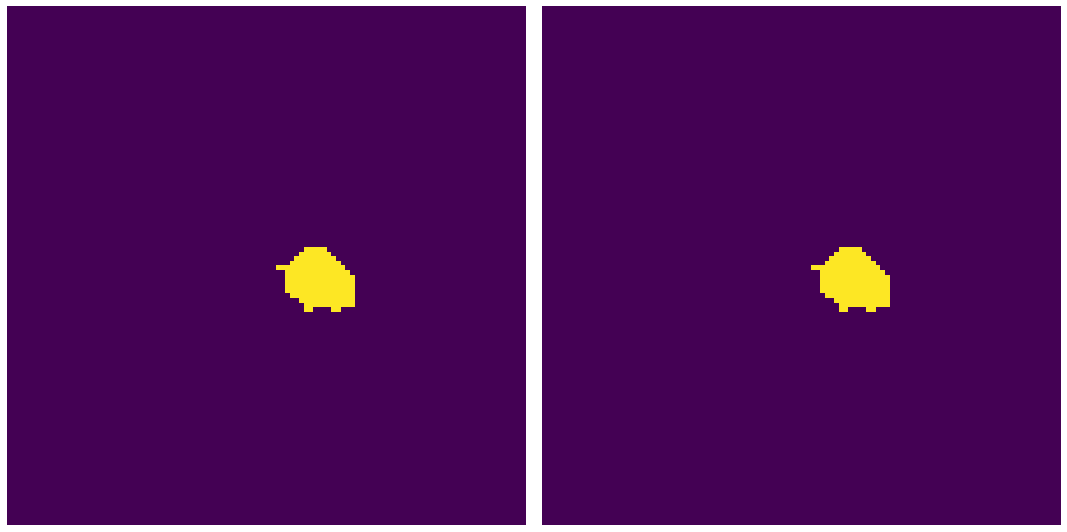

1.0


In [228]:
ne.plot.slices([lab[0][:,:,9], lab[0][:,:,9]])
print(dice)

In [131]:
np_frames_no_masks[0][0][30:60,30:60,18]

array([[106, 107, 107, 107, 106, 106, 106, 106, 106, 107, 108, 108, 108,
        108, 107, 106, 106, 106, 105, 105, 105, 106, 106, 106, 106, 106,
        106, 106, 106, 106],
       [106, 106, 106, 106, 106, 106, 106, 106, 106, 108, 110, 112, 113,
        112, 110, 107, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106,
        106, 106, 106, 106],
       [106, 106, 106, 106, 106, 106, 106, 106, 107, 109, 114, 122, 127,
        120, 114, 108, 106, 106, 106, 106, 106, 106, 106, 106, 106, 105,
        106, 106, 106, 106],
       [106, 106, 106, 106, 106, 106, 106, 107, 107, 110, 121, 135, 141,
        132, 121, 110, 106, 106, 106, 106, 106, 106, 106, 106, 105, 105,
        105, 106, 106, 106],
       [106, 106, 106, 106, 107, 107, 107, 107, 109, 110, 116, 128, 135,
        129, 118, 111, 108, 107, 108, 108, 107, 106, 106, 106, 106, 105,
        106, 106, 106, 106],
       [106, 106, 106, 106, 107, 107, 107, 107, 108, 109, 111, 116, 121,
        118, 111, 109, 108, 108, 108, 108, 107, 106,

In [116]:
overlap.shape

(8,)

In [79]:
y_true.get_shape()

TensorShape([1, 112, 112, 32])

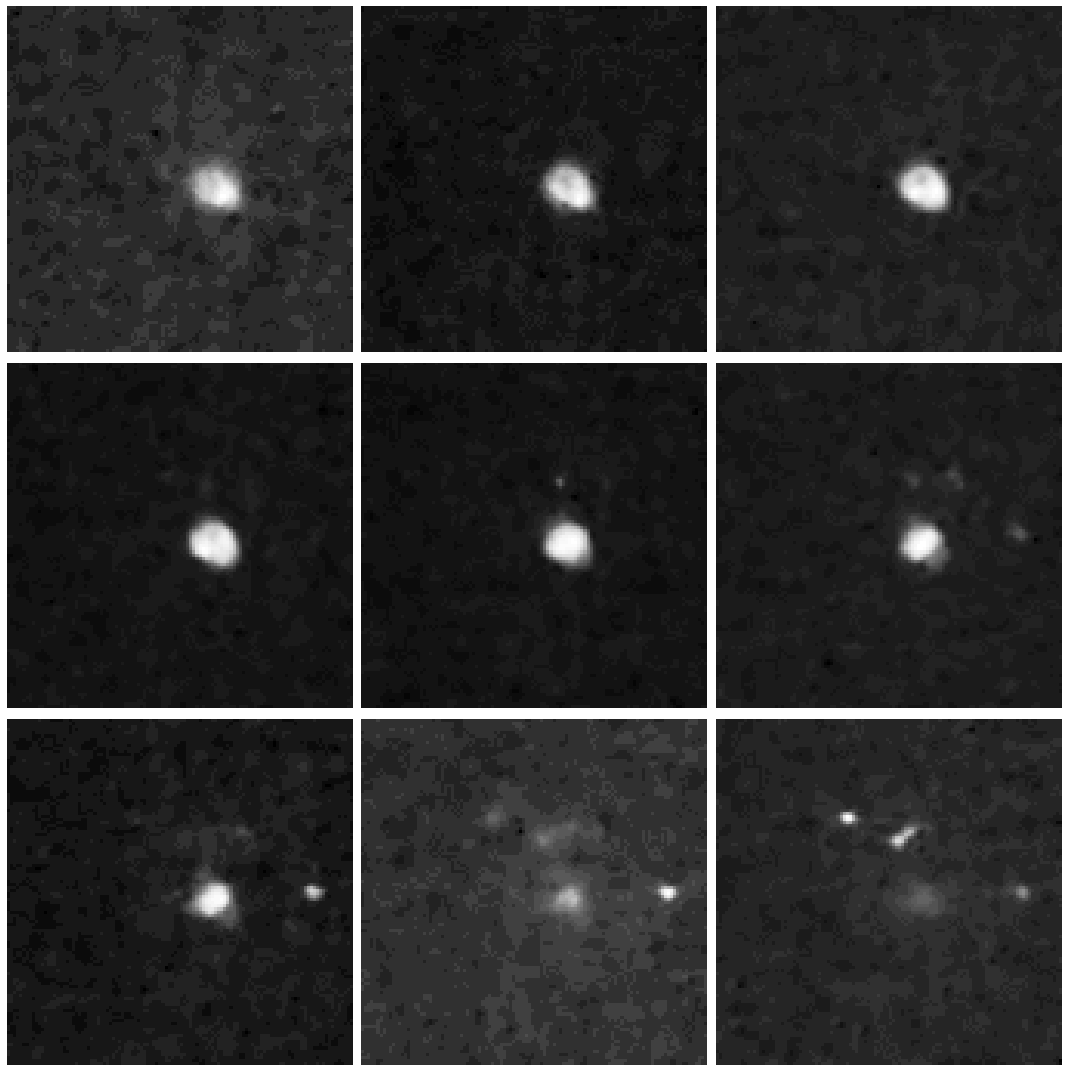

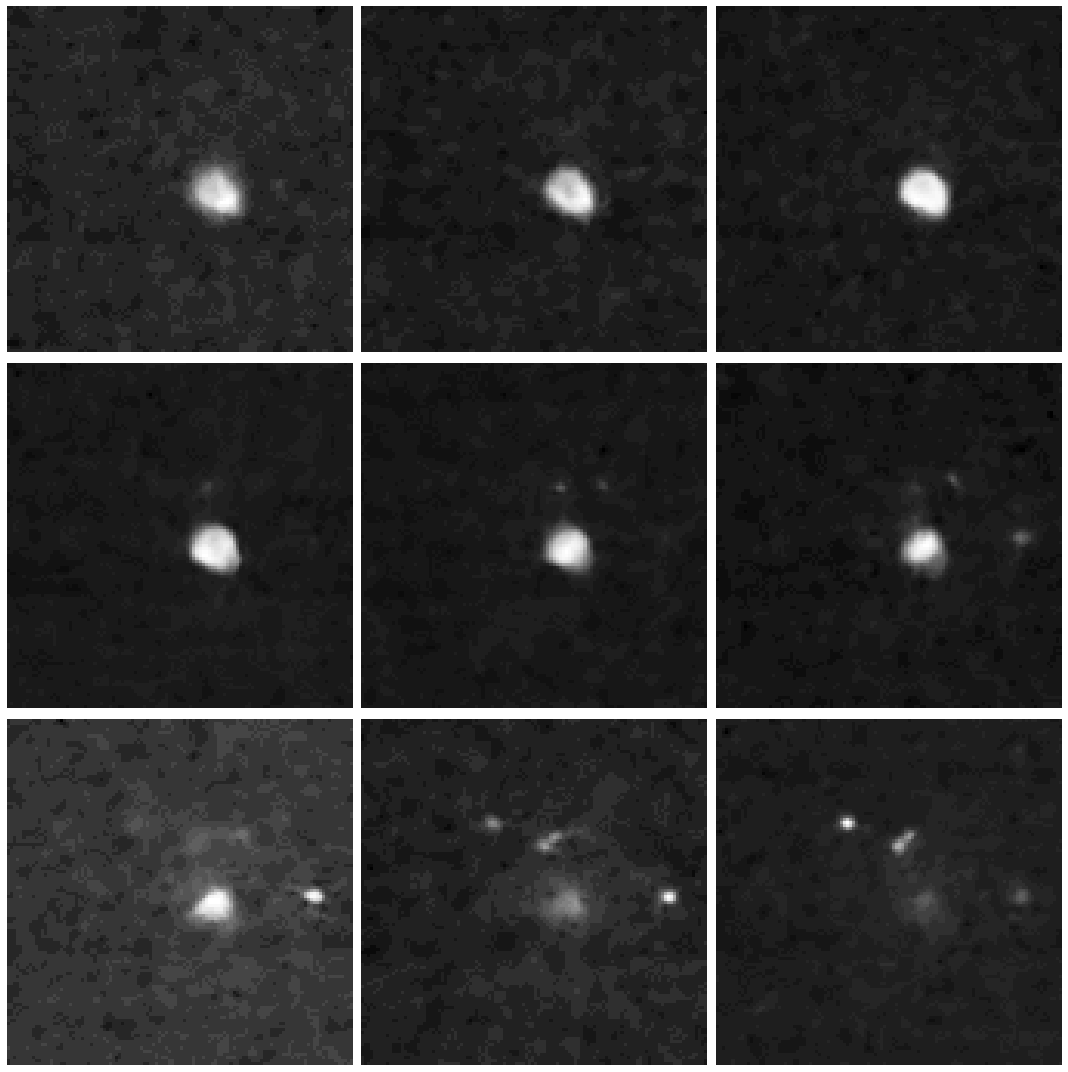

(<Figure size 1080x1080 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000275D7BC8>,
       dtype=object))

In [130]:
ne.plot.slices([np_frames_masks[0][0][:,:,i+10] for i in range(9)], cmaps=['Greys_r'], grid = (3,3))
ne.plot.slices([np_frames_no_masks[0][0][:,:,i+10] for i in range(9)], cmaps=['Greys_r'], grid = (3,3))

In [ ]:
class Dice:
    """
    N-D dice for segmentation
    """

    def loss(self, y_true, y_pred):
        ndims = len(y_pred.get_shape().as_list()) - 2
        vol_axes = list(range(1, ndims+1))

        top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
        bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

        div_no_nan = tf.math.divide_no_nan if hasattr(tf.math, 'divide_no_nan') else tf.div_no_nan
        dice = tf.reduce_mean(div_no_nan(top, bottom))
        return -dice

In [1]:
import os, sys

# voxel morph imports
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import numpy as np
import scipy.ndimage as ndi
import h5py
import cv2

import utilitary as util

#plotting
import matplotlib.pyplot as plt

In [2]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

hf = h5py.File("../epfl3.h5", "r")

In [3]:
nb_entries = len(hf.keys())
list_keys = list(hf.keys())
keys_random = np.random.permutation(list_keys)

keys_train = keys_random[:int(nb_entries*0.8)]
keys_test  = keys_random[int(nb_entries*0.8):]

In [4]:
#load the training set + normalization
slices_train = np.empty((len(keys_train),112,112,32), dtype=np.int16)
for i, key in enumerate(keys_train):
    slices_train[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255